The Problem: Image Classification
We are tackling the challenge of classifying images of dogs by their emotional expressions: happy, sad, angry, and relaxed. Each image captures a range of canine facial cues and body language that correspond to these emotions. The goal is to accurately assign one of these labels to each image, enabling us to understand and better respond to the emotional states of dogs. This classification task not only aids in enhancing human-dog interactions but also serves as a stepping stone towards more empathetic and responsive pet care systems.

# Import libraries


In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score ,precision_score,recall_score,f1_score
import pandas as pd
import os
import cv2
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import seaborn as sns; sns.set()
from sklearn.metrics import classification_report

# Link the notbook to Kaggle to fetch the dataset

In [ ]:
#install kaggle
!pip install -q kaggle

In [ ]:
# upload json file into colab
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"randfahad","key":"22b326183c22a2c4b06c0fb3fa421029"}'}

In [ ]:
#Make a directory named “.kaggle”
!mkdir ~/.kaggle

In [ ]:
#Copy the “kaggle.json” into this new directory
! cp kaggle.json ~/.kaggle/

In [ ]:
#Allocate the required permission for this file.

! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the dog-emotions-prediction dataset
! kaggle datasets download  devzohaib/dog-emotions-prediction

##! kaggle datasets download danielshanbalico/dog-emotion

 95% 361M/379M [00:02<00:00, 103MB/s] 
100% 379M/379M [00:02<00:00, 138MB/s]


In [ ]:
# unzip the dataset
!unzip dog-emotions-prediction.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/relaxed/7589753254_ee8544b568_b.jpg  
  inflating: images/relaxed/759543680_39c2ae5902_b.jpg  
  inflating: images/relaxed/7609431744_595047309c_b.jpg  
  inflating: images/relaxed/7613797848_52b6e2a4ac_b.jpg  
  inflating: images/relaxed/7618277504_12a9e58577_b.jpg  
  inflating: images/relaxed/7623026172_ee5fc5af84_b.jpg  
  inflating: images/relaxed/7623956526_5c55bfee35_b.jpg  
  inflating: images/relaxed/7630905134_0993274875_b.jpg  
  inflating: images/relaxed/7650586470_bab16e618f_b.jpg  
  inflating: images/relaxed/7650586740_f0a1e71f48_b.jpg  
  inflating: images/relaxed/7650587218_e8b69b8453_b.jpg  
  inflating: images/relaxed/7653104926_b172a2fc23_b.jpg  
  inflating: images/relaxed/7654628694_ca31b3633d_b.jpg  
  inflating: images/relaxed/7655545926_1288ab5e93_b.jpg  
  inflating: images/relaxed/7659667864_2b1d26a896_b.jpg  
  inflating: images/relaxed/7662075476_bc5b0b0ddf_b.jpg  
  inflating: images/re

# Read the images in each folder and read the labels
we have a directory named images which contains subdirectories for each emotion (e.g., happy, angry, relaxed, sad). Inside each emotion subdirectory, there should be images related to that particular emotion.

The function load_data loads images from each emotion folder and performs the following steps:

Iterate through each emotion using enumerate(emotions).
Set the x variable to track the number of images loaded from each folder.
Iterate through each file in the emotion folder using os.listdir(emotion_dir).
Check if the desired number of images (1000 in this case) has been loaded from the folder. If yes, break the loop.
Construct the path to the image file using os.path.join(emotion_dir, filename).
Read the image using cv2.imread and convert it to grayscale using cv2.cvtColor.
Resize the image to a fixed size of 96x96 pixels using cv2.resize.
Flatten the image into a 1D array using img.flatten().
Append the flattened image to the images list.
Assign a label/index to the image based on the emotion using labels.append(i).
Increment the counter variable.
After processing all the images, convert the images and labels lists to numpy arrays using np.array.
Finally, the function returns the images and labels numpy arrays, representing the preprocessed image data and corresponding labels, respectively.

In [ ]:
data_dir='/content/images'
num=1000
def load_data():
  x=0
  emotions = ['happy', 'angry', 'relaxed', 'sad']
  images = []
  labels = []

  for i, emotion in enumerate(emotions):
    x=0
    emotion_dir = os.path.join(data_dir, emotion)
    for filename in os.listdir(emotion_dir):

      img_path = os.path.join(emotion_dir, filename)
      img = cv2.imread(img_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      img = cv2.resize(img, (96, 96))  # Resize the image to a fixed size
      img=img.flatten()
      images.append(img)
      labels.append(i)
      if x==num:
        break
      x=x+1
  images = np.array(images)
  labels = np.array(labels)
  return images,labels

# Call the function

In [ ]:
images, labels = load_data()

In [ ]:
print(labels)

[0 0 0 ... 3 3 3]


# Split the dataset into train and test 80% for train set and 20% for test set
Split your dataset into two subsets: a training set and a testing set. The training set will be used to train the SVM model, while the testing set will be used to evaluate its performance. Typically, a 70-30 or 80-20 split is used, with the majority of the data allocated to training.

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(images,labels,test_size=0.20,
                                               random_state=42,
                                       stratify=labels)

print("X_train shape: {}".format(x_train.shape))
print("X_test shape: {}".format(x_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (3203, 9216)
X_test shape: (801, 9216)
y_train shape: (3203,)
y_test shape: (801,)


# Normilze the images(Pixels)to make the training time faster and increase the performance for the model


In [ ]:
# make the pixels of image range between 0 and 1 that leads to faster training and increase the acc
x_train=x_train/255.0
x_test=x_test/255.0

# Dimension reduction using PCA
The plot depicts the relationship between the number of components used and the amount of variance captured in the data. By observing the elbow point on the plot, which occurred around 100 components, we can determine the optimal number of components to retain. This point indicates the number of components where a significant portion of the data's variance is accounted for, suggesting that additional components may not contribute significantly to the overall understanding of the data.

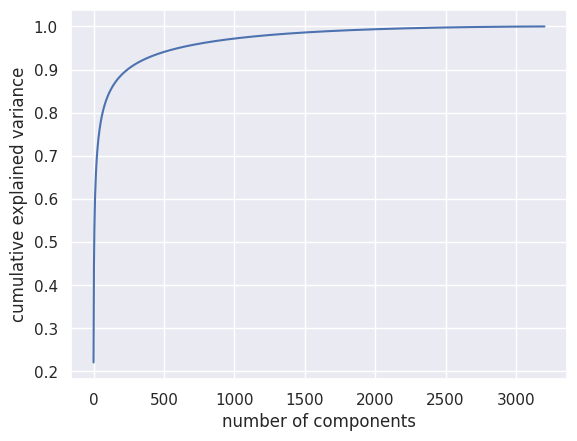

In [ ]:
from sklearn.decomposition import PCA
pca = PCA().fit(x_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

# Model Training
We created a PCA model to extract the essential features from the data, reducing its dimensionality. Then, we built an SVM model using a linear kernel for classification. To combine these models, we created a pipeline. After fitting the pipeline on the training data, we used it to predict labels for the test data. This approach allows us to efficiently leverage the benefits of both PCA and SVM for accurate predictions on new data.

In [ ]:
pca = PCA(100).fit(x_train)
linear = svm.SVC(kernel='linear', gamma=0.010, C=5).fit(x_train, y_train)
model = make_pipeline(pca, linear)
linear_pred = linear.predict(x_test)

In [ ]:
linear_accuracy = accuracy_score(y_test, linear_pred)
linear_f1 = f1_score(y_test, linear_pred, average='weighted')
print('Accuracy (linear Kernel): ', "%.2f" % (linear_accuracy*100))
print('F1 (linear Kernel): ', "%.2f" % (linear_f1*100))

Accuracy (linear Kernel):  24.59
F1 (linear Kernel):  24.54


# Hyperparameter Tuning:
To optimize our SVM model with a linear kernel, we performed a grid search to find the best combination of hyperparameters, specifically "C" and "gamma". By systematically exploring different parameter values, we aimed to maximize the model's performance for our dataset and problem. This approach allows us to fine-tune the SVM model and achieve optimal results.

In [ ]:
param_grid = {'svc__C': [1, 5, 10],
              'svc__gamma': [0.0005, 0.001, 0.010]}

grid = GridSearchCV(model, param_grid, verbose=2)

# Measure the time for the first fit
%time grid.fit(x_train, y_train)



Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ........................svc__C=1, svc__gamma=0.0005; total time=  39.3s
[CV] END ........................svc__C=1, svc__gamma=0.0005; total time=  36.1s
[CV] END ........................svc__C=1, svc__gamma=0.0005; total time=  42.1s
[CV] END ........................svc__C=1, svc__gamma=0.0005; total time=  37.2s
[CV] END ........................svc__C=1, svc__gamma=0.0005; total time=  43.2s
[CV] END .........................svc__C=1, svc__gamma=0.001; total time=  38.6s
[CV] END .........................svc__C=1, svc__gamma=0.001; total time=  35.8s
[CV] END .........................svc__C=1, svc__gamma=0.001; total time=  38.1s
[CV] END .........................svc__C=1, svc__gamma=0.001; total time=  43.1s
[CV] END .........................svc__C=1, svc__gamma=0.001; total time=  35.4s
[CV] END ..........................svc__C=1, svc__gamma=0.01; total time=  37.6s
[CV] END ..........................svc__C=1, svc_

GridSearchCV(estimator=Pipeline(steps=[('pca', PCA(n_components=100)),
                                       ('svc',
                                        SVC(C=5, gamma=0.01,
                                            kernel='linear'))]),
             param_grid={'svc__C': [1, 5, 10],
                         'svc__gamma': [0.0005, 0.001, 0.01]},
             verbose=2)

In [ ]:
print(f'Best parameters are: {grid.best_params_}')
mean_score = grid.cv_results_['mean_test_score']
std_score = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean,std,params in zip(mean_score,std_score,params):
      print(f'{round(mean,2)} + or -{round(std,2)} for the {params}')

Best parameters are: {'svc__C': 1, 'svc__gamma': 0.0005}
0.28 + or -0.01 for the {'svc__C': 1, 'svc__gamma': 0.0005}
0.27 + or -0.02 for the {'svc__C': 1, 'svc__gamma': 0.001}
0.27 + or -0.01 for the {'svc__C': 1, 'svc__gamma': 0.01}
0.27 + or -0.01 for the {'svc__C': 5, 'svc__gamma': 0.0005}
0.27 + or -0.01 for the {'svc__C': 5, 'svc__gamma': 0.001}
0.27 + or -0.01 for the {'svc__C': 5, 'svc__gamma': 0.01}
0.27 + or -0.01 for the {'svc__C': 10, 'svc__gamma': 0.0005}
0.27 + or -0.01 for the {'svc__C': 10, 'svc__gamma': 0.001}
0.28 + or -0.01 for the {'svc__C': 10, 'svc__gamma': 0.01}


# Evaluation

In [ ]:
model = grid.best_estimator_
y_pred = model.predict(x_test)

##calculate and print the accuracy and f1 scores for SVM with best RBF kernel:
bestlinear_accuracy = accuracy_score(y_test, y_pred)
bestlinear_f1 = f1_score(y_test, y_pred, average='weighted')
print('Accuracy (Best linear Kernel): ', "%.2f" % (bestlinear_accuracy*100))
print('F1 (Best linear Kernel): ', "%.2f" % (bestlinear_f1*100))

Accuracy (Best linear Kernel):  29.09
F1 (Best linear Kernel):  28.86


In [ ]:
print(classification_report(y_test, y_pred
                            ))

              precision    recall  f1-score   support

           0       0.31      0.33      0.32       200
           1       0.29      0.29      0.29       200
           2       0.26      0.20      0.23       201
           3       0.30      0.34      0.32       200

    accuracy                           0.29       801
   macro avg       0.29      0.29      0.29       801
weighted avg       0.29      0.29      0.29       801



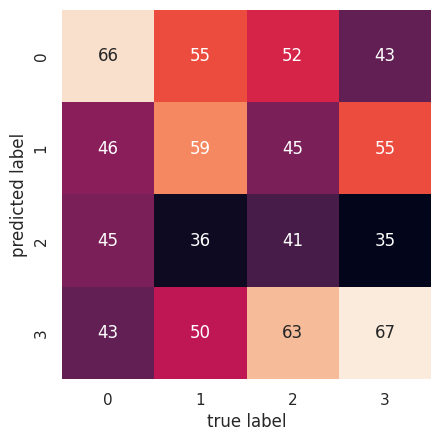

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False,
            )
plt.xlabel('true label')
plt.ylabel('predicted label');